# Spectrograph Design Widget


This tool allows you to play with a spectograph design

In [1]:
%matplotlib inline
import pylab as pl
import numpy as np
from astropy import units as u, constants, visualization
from astropy.convolution import convolve
visualization.quantity_support()
pl.style.use('dark_background')
from ipywidgets import interact, interactive, fixed, interact_manual, widgets, HBox

In [2]:
def makeplot(wavelength = 500, # nm
             separation = 4, # um
             gapwidth = 0.5, # um
             norders = 16,
             sz=4096, # controls resolution of output
            ):
    
    wavelength = u.Quantity(wavelength, u.nm)
    separation = u.Quantity(separation, u.um)
    gapwidth = u.Quantity(gapwidth, u.um)
    
    
    assert gapwidth < separation

    
    gapwidth_pix = gapwidth / separation * norders
    kernel=[1] * int(gapwidth_pix)
    if len(kernel) == 0:
        kernel = [1]
        print("Grating lines are infinitesimal")
    elif len(kernel) % 2 == 0:
        kernel[-1] = 0.5
        kernel[0] =0.5
        kernel.append(0)
    
    

    separation_pixels = norders

    angle_to_first_order = np.arcsin(wavelength / separation).to(u.deg)
    
    angle_to_first_peak = np.arcsin(wavelength/separation).to(u.deg)
   
    
    ftax = np.fft.fftshift(np.fft.fftfreq(sz)*norders * angle_to_first_order)

    twoslit = np.zeros(sz)
    twoslit[:norders*2:norders] = 1
    fourslit = twoslit.copy()
    fourslit[:norders*4:norders] = 1
    sixslit = fourslit.copy()
    sixslit[:norders*6:norders] = 1
    eightslit = sixslit.copy()
    eightslit[:norders*8:norders] = 1
    assert eightslit.sum() == 8
    

    fourslitsm = convolve(fourslit, kernel)
    twoslitsm = convolve(twoslit, kernel)
    sixslitsm = convolve(sixslit, kernel)
    eightslitsm = convolve(eightslit, kernel)


    twoslitft = np.abs(np.fft.fft(twoslitsm/twoslitsm.sum())**2)
    fourslitft = np.abs(np.fft.fft(fourslitsm/fourslitsm.sum())**2)
    sixslitft = np.abs(np.fft.fft(sixslitsm/sixslitsm.sum())**2)
    eightslitft = np.abs(np.fft.fft(eightslitsm/eightslitsm.sum())**2)

    #pl.plot(np.fft.fftshift(twoslitft))
    pl.figure(figsize=(12,8))
    pl.plot(ftax, np.fft.fftshift(twoslitft), '-.', label='2-gap')
    pl.plot(ftax, np.fft.fftshift(fourslitft), ':', label='4-gap')
    pl.plot(ftax, np.fft.fftshift(sixslitft), '--', label='6-gap')
    pl.plot(ftax, np.fft.fftshift(eightslitft), label='8-gap')

    pl.xlabel("Angular Separation (deg)")
    pl.text(1*u.deg, 0.95, "0th", fontsize=18)

    pkval1 = twoslitft[np.argmin(np.abs(np.fft.fftshift(ftax) - angle_to_first_peak))]
    pkval2 = twoslitft[np.argmin(np.abs(np.fft.fftshift(ftax) - angle_to_first_peak*2))]

    pl.text(angle_to_first_peak + 1*u.deg, pkval1, "1st", fontsize=18)
    pl.text(angle_to_first_peak*2 + 2*u.deg, pkval2, "2nd", fontsize=18)


    pl.legend(loc='upper right', fontsize=18)

interactive(children=(IntSlider(value=500, description='Wavelength (nm)', max=800, min=400, step=25, style=Sli…

<function __main__.makeplot(wavelength=500, separation=4, gapwidth=0.5, norders=16, sz=4096)>

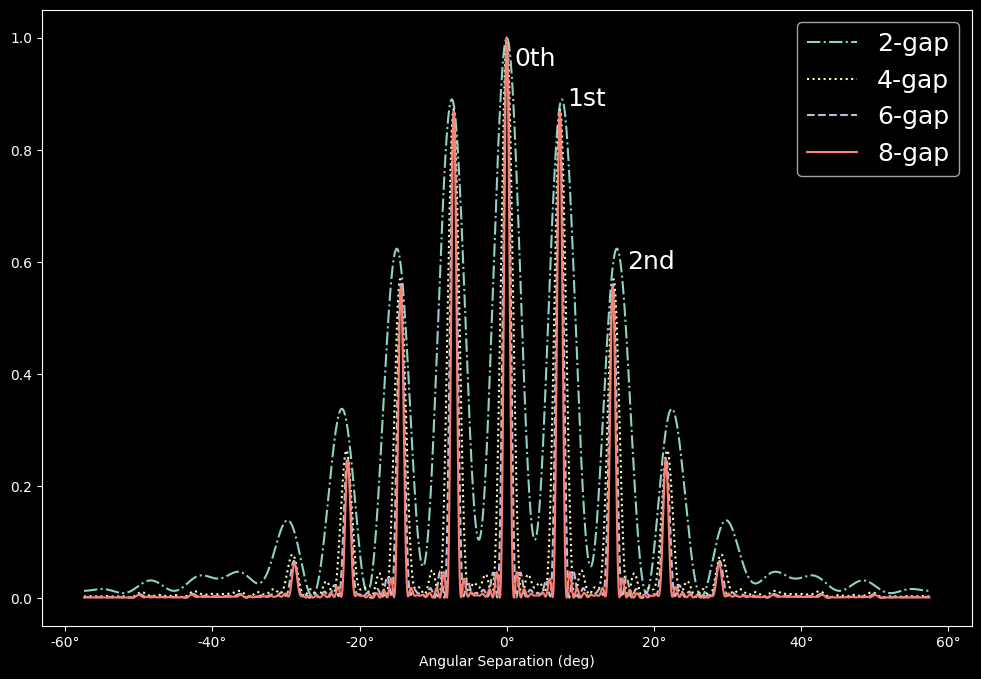

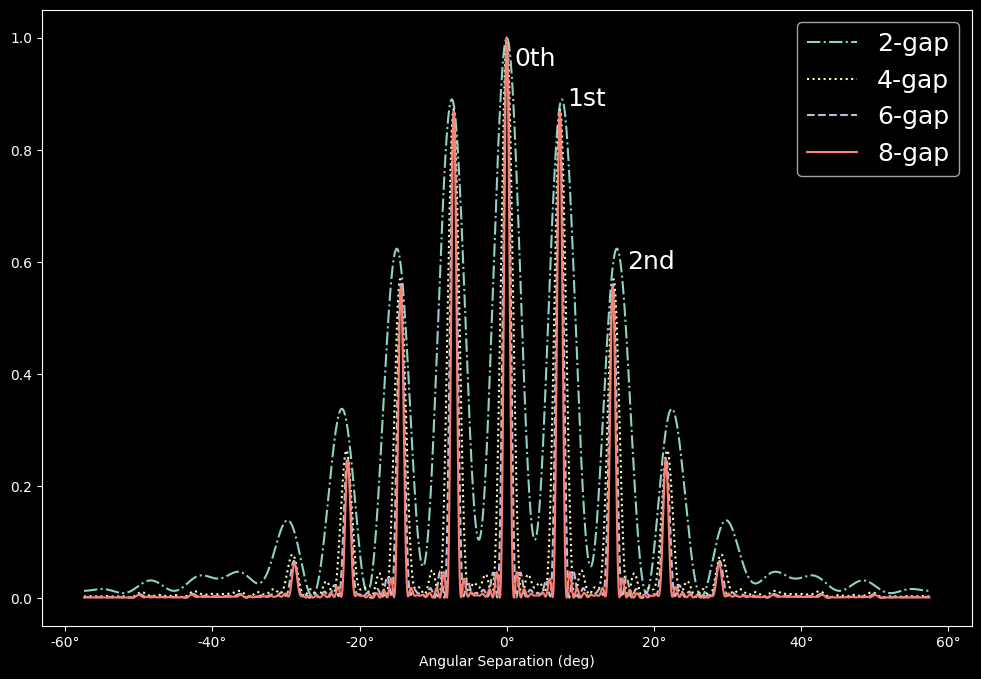

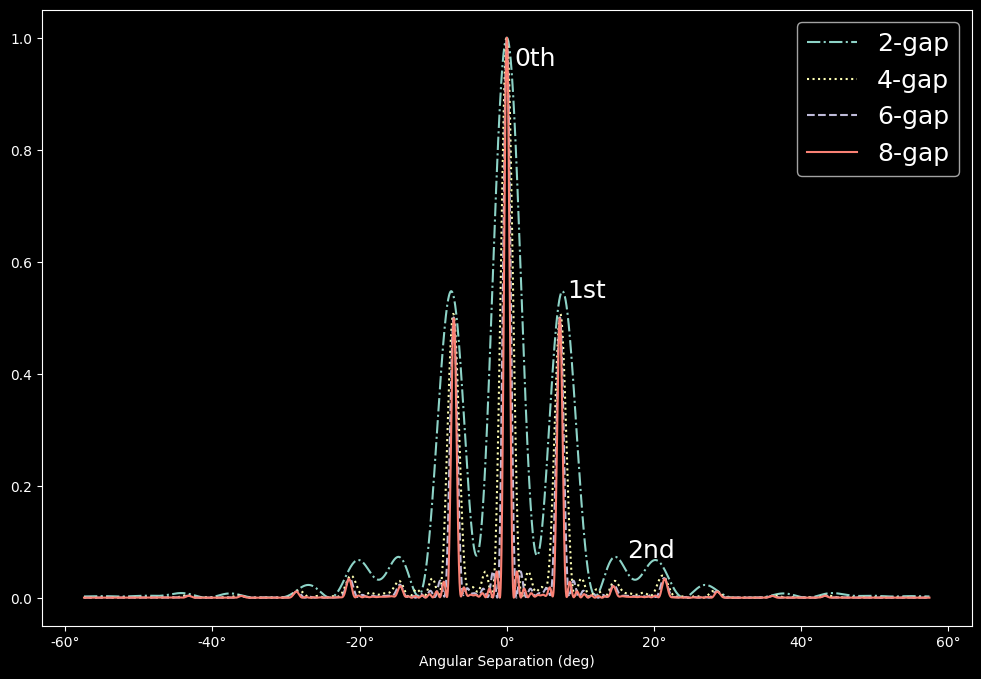

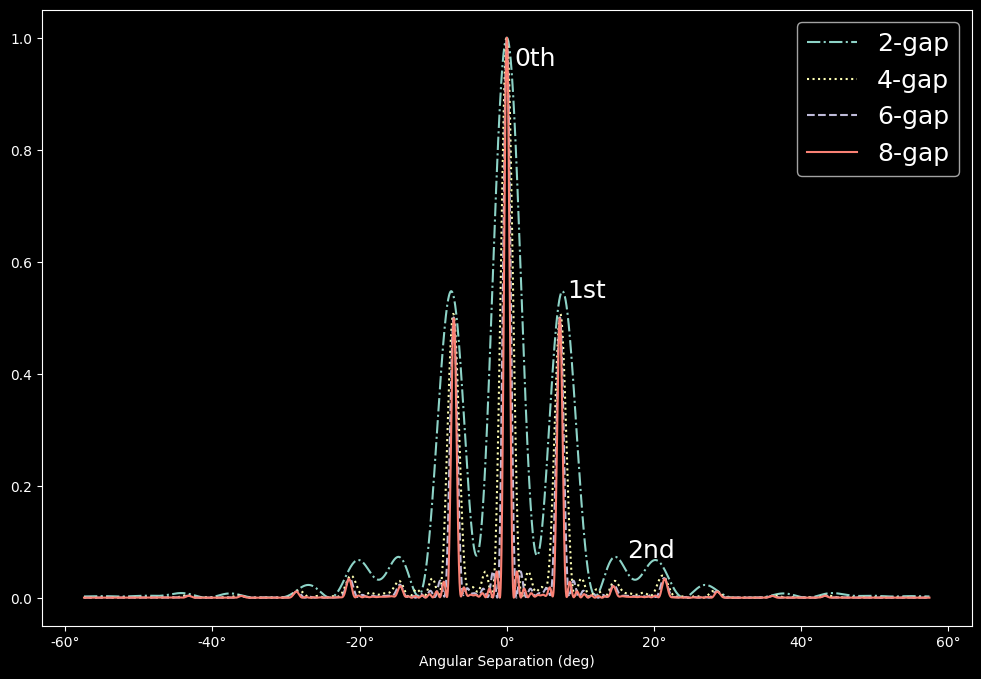

In [3]:
style={'description_width':'50%'}
interact(makeplot,
         wavelength=widgets.IntSlider(min=400, max=800, step=25, value=500, description="Wavelength (nm)", style=style),
         separation=widgets.FloatSlider(min=1, max=10, value=4, step=0.2, description="Line Separation (um)", style=style),
         gapwidth=widgets.FloatSlider(min=0.5, max=4, value=1, description='Grating Line Width (um)', style=style),
         sz=widgets.IntSlider(min=256, max=8192, step=128, value=4096, description='number of pixels used', style=style),
         norders=widgets.IntSlider(min=2, max=32, step=1, value=16, description='# of orders to show', style=style)
)